In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
merged_dir = "../../../data/merged"
image_dir = "../../../images/DBSCAN"

In [3]:
fire_file_path = os.path.join(merged_dir, "fire_land_elev_soil_climate.parquet")
data = pd.read_parquet(fire_file_path)
X = data.drop(columns=['fire','longitude', 'latitude'])
y = data['fire']

In [4]:
# use one hot encoding on LCCCode
X = pd.get_dummies(X, columns=['LCCCode'], drop_first=True)
# Check dtypes again
print(X.dtypes)
# check nan
print(X.isna().sum())

elevation                                  int64
COARSE                                   float64
SAND                                     float64
CLAY                                     float64
TCARBON_EQ                               float64
PH_WATER                                 float64
TOTAL_N                                  float64
CN_RATIO                                 float64
CEC_SOIL                                 float64
ESP                                      float64
GYPSUM                                   float64
prec_median_autumn                       float64
prec_median_spring                       float64
prec_median_summer                       float64
prec_median_winter                       float64
tmin_median_autumn                       float64
tmin_median_spring                       float64
tmin_median_summer                       float64
tmin_median_winter                       float64
tmax_median_autumn                       float64
tmax_median_spring  

In [5]:
eps_values = [0.2, 0.3, 0.5, 0.7, 1.0]
min_samples_values = [5, 10, 20]
scalers = {
    "none": None,
    "standard": StandardScaler(),
    "robust": RobustScaler()
}

In [6]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

results_dbscan = []

pt = PowerTransformer(method='yeo-johnson')

for scaler_name, scaler in scalers.items():
    for use_pt in [True, False]:

        # ---- preprocessing ----
        X_proc = X.copy().astype(float)

        if use_pt:
            X_proc = pt.fit_transform(X_proc)

        if scaler is not None:
            X_proc = scaler.fit_transform(X_proc)

        # ---- DBSCAN search ----
        for eps in eps_values:
            for min_samples in min_samples_values:

                db = DBSCAN(eps=eps, min_samples=min_samples)
                labels = db.fit_predict(X_proc)

                # Count clusters (ignore noise = -1)
                unique_labels = set(labels)
                n_clusters = len(unique_labels - {-1})
                noise_ratio = np.mean(labels == -1)

                # Skip degenerate cases
                if n_clusters < 2:
                    continue

                # Metrics only on non-noise points
                mask = labels != -1

                sil = silhouette_score(X_proc[mask], labels[mask])
                dbi = davies_bouldin_score(X_proc[mask], labels[mask])

                print(
                    f"DBSCAN eps={eps}, min_samples={min_samples}, "
                    f"scaler={scaler_name}, yeo={use_pt}, clusters={n_clusters}"
                )

                results_dbscan.append({
                    "eps": eps,
                    "min_samples": min_samples,
                    "scaler": scaler_name,
                    "yeo_johnson": use_pt,
                    "n_clusters": n_clusters,
                    "noise_ratio": noise_ratio,
                    "silhouette": sil,
                    "davies_bouldin": dbi
                })

# Results dataframe
dbscan_df = pd.DataFrame(results_dbscan)
dbscan_df = dbscan_df.sort_values(
    ["silhouette", "noise_ratio"],
    ascending=[False, True]
).reset_index(drop=True)

print("Top DBSCAN configurations:")
print(dbscan_df.head(10))


DBSCAN eps=0.2, min_samples=5, scaler=none, yeo=True, clusters=1056
DBSCAN eps=0.2, min_samples=10, scaler=none, yeo=True, clusters=72
DBSCAN eps=0.2, min_samples=20, scaler=none, yeo=True, clusters=21
DBSCAN eps=0.3, min_samples=5, scaler=none, yeo=True, clusters=1154
DBSCAN eps=0.3, min_samples=10, scaler=none, yeo=True, clusters=109
DBSCAN eps=0.3, min_samples=20, scaler=none, yeo=True, clusters=26
DBSCAN eps=0.5, min_samples=5, scaler=none, yeo=True, clusters=1306
DBSCAN eps=0.5, min_samples=10, scaler=none, yeo=True, clusters=236
DBSCAN eps=0.5, min_samples=20, scaler=none, yeo=True, clusters=71
DBSCAN eps=0.7, min_samples=5, scaler=none, yeo=True, clusters=1541
DBSCAN eps=0.7, min_samples=10, scaler=none, yeo=True, clusters=382
DBSCAN eps=0.7, min_samples=20, scaler=none, yeo=True, clusters=112
DBSCAN eps=1.0, min_samples=5, scaler=none, yeo=True, clusters=1391
DBSCAN eps=1.0, min_samples=10, scaler=none, yeo=True, clusters=497
DBSCAN eps=1.0, min_samples=20, scaler=none, yeo=Tru

In [7]:
best_row = dbscan_df.iloc[0]
print("Best configuration:")
print(best_row)

Best configuration:
eps                    0.2
min_samples              5
scaler                none
yeo_johnson          False
n_clusters              65
noise_ratio       0.972997
silhouette             1.0
davies_bouldin    0.000001
Name: 0, dtype: object


In [8]:
dbscan_df_clean = dbscan_df[
    (dbscan_df["n_clusters"] > 1) &
    (~dbscan_df["silhouette"].isna())
].copy()


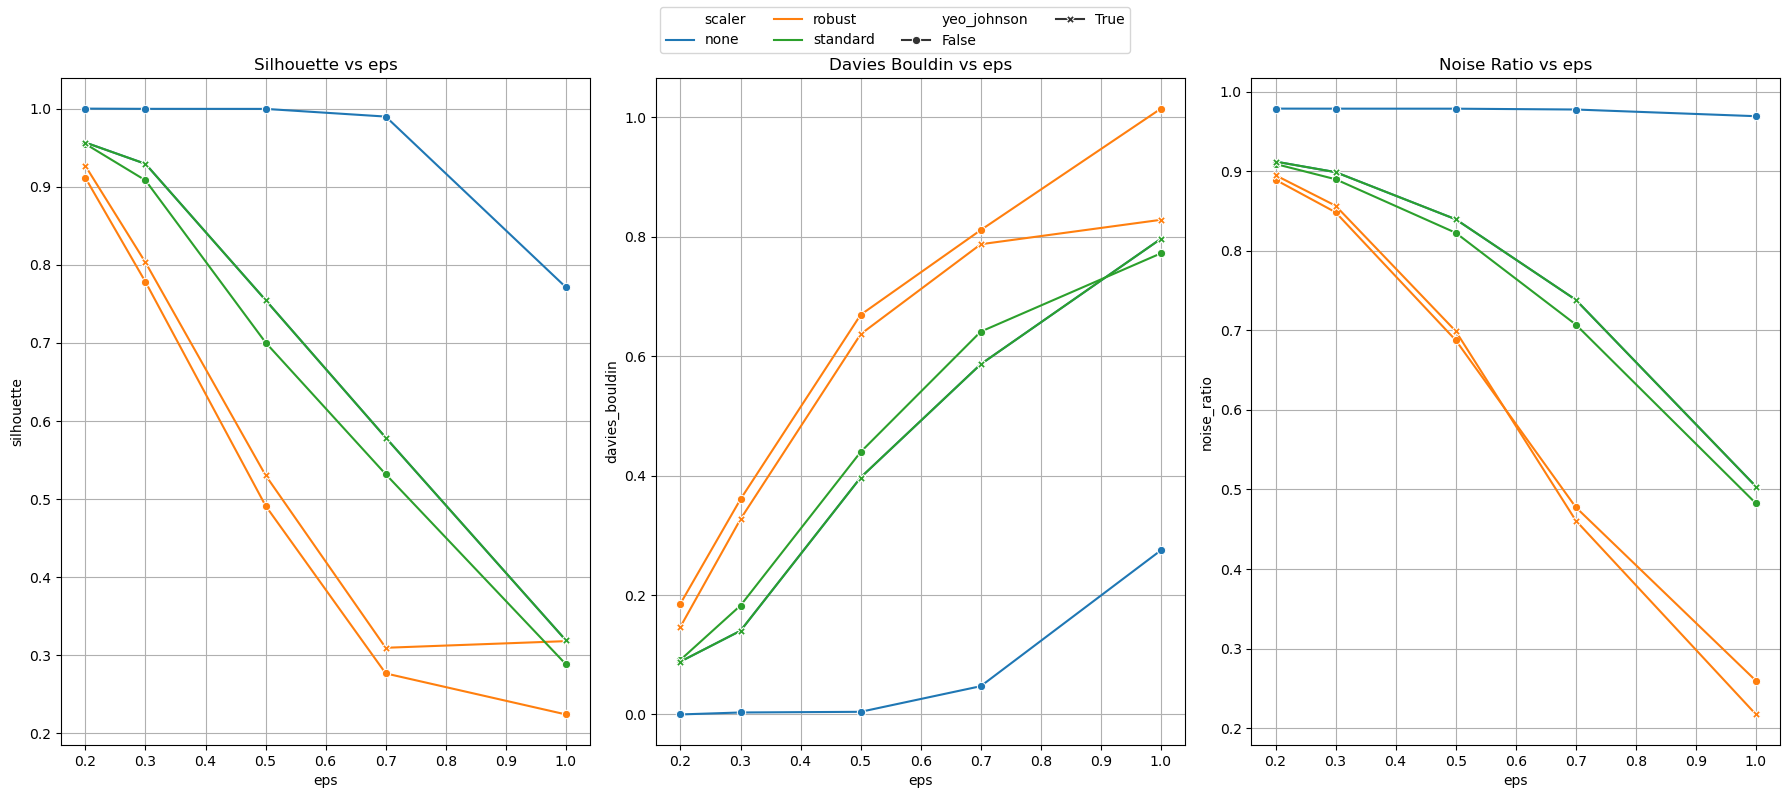

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = [
    "silhouette",
    "davies_bouldin",
    "noise_ratio"
]

fig, axes = plt.subplots(1, 3, figsize=(18, 8))
axes = axes.flatten()

for ax, metric in zip(axes, metrics):

    eps_df = (
        dbscan_df_clean
        .groupby(["eps", "scaler", "yeo_johnson"])[metric]
        .mean()
        .reset_index()
    )

    sns.lineplot(
        data=eps_df,
        x="eps",
        y=metric,
        hue="scaler",
        style="yeo_johnson",
        markers=True,
        dashes=False,
        ax=ax
    )

    ax.set_title(f"{metric.replace('_', ' ').title()} vs eps")
    ax.grid(True)
    ax.legend_.remove()

# Keep legend only once
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=4)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


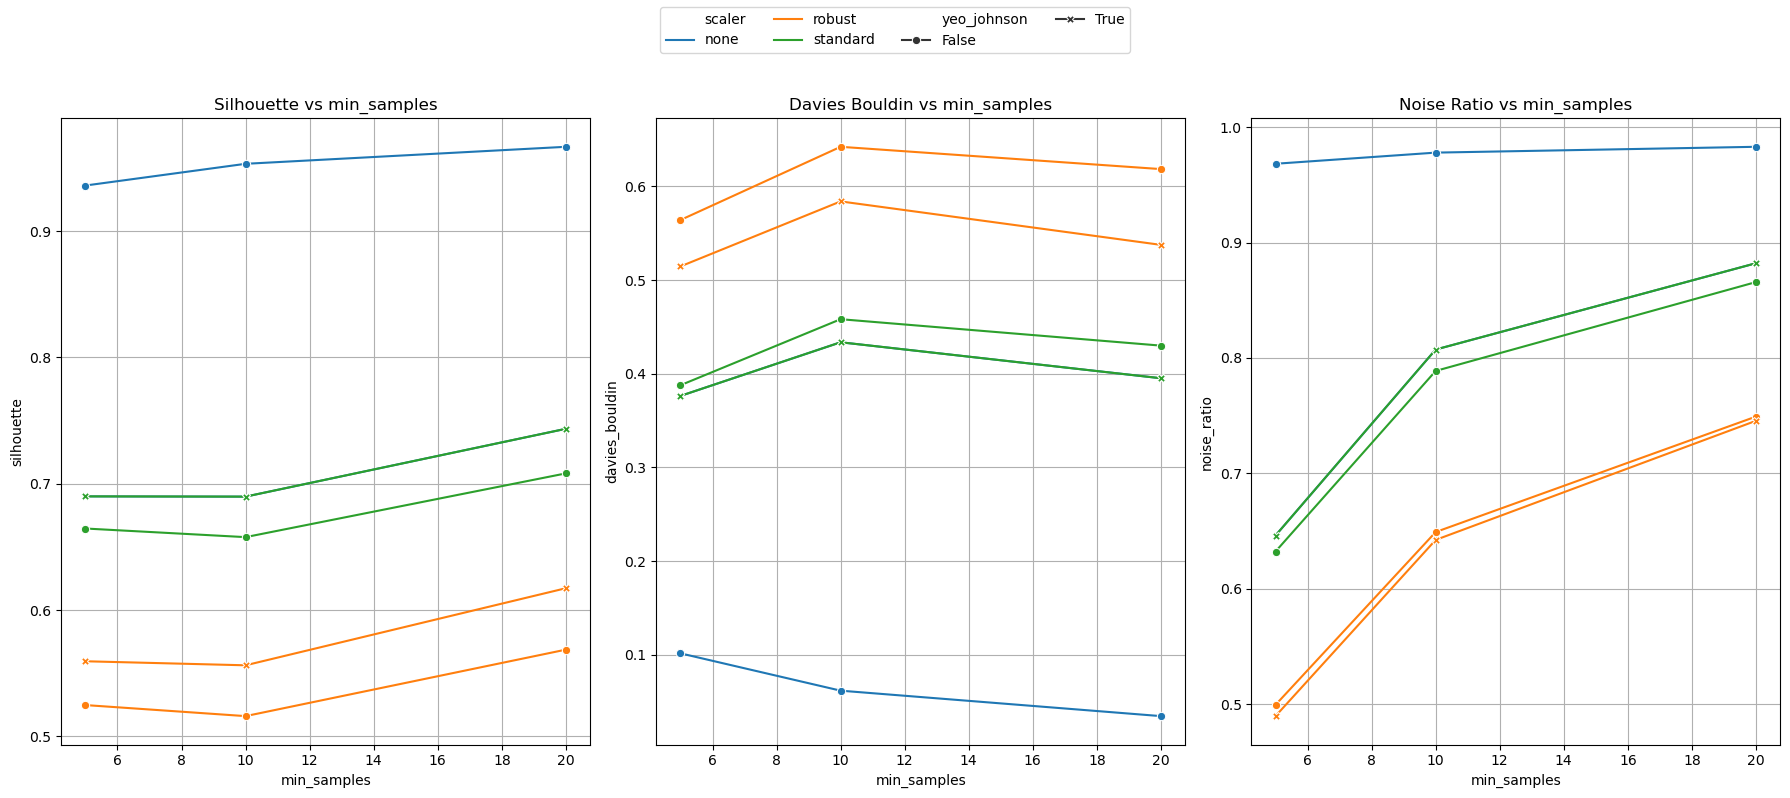

In [44]:
metrics = [
    "silhouette",
    "davies_bouldin",
    "noise_ratio"
]

fig, axes = plt.subplots(1, 3, figsize=(18, 8))  

for ax, metric in zip(axes, metrics):

    min_df = (
        dbscan_df_clean
        .groupby(["min_samples", "scaler", "yeo_johnson"])[metric]
        .mean()
        .reset_index()
    )

    sns.lineplot(
        data=min_df,
        x="min_samples",
        y=metric,
        hue="scaler",
        style="yeo_johnson",
        markers=True,
        dashes=False,
        ax=ax
    )

    ax.set_title(f"{metric.replace('_', ' ').title()} vs min_samples")
    ax.set_xlabel("min_samples")
    ax.grid(True)
    ax.legend_.remove()

# 🔹 One shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=4)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


In [74]:
best_eps = 0.5
best_min_samples = 20
best_scaler_name = 'robust'
best_yeo_johnson = True


# =========================
# 2. Preprocess data
# =========================
X_proc = X.copy().astype(float)

if best_yeo_johnson:
    pt = PowerTransformer(method="yeo-johnson")
    X_proc = pt.fit_transform(X_proc)

scaler_dict = {
    "none": None,
    "standard": StandardScaler(),
    "robust": RobustScaler()
}

scaler = scaler_dict[best_scaler_name]
if scaler is not None:
    X_proc = scaler.fit_transform(X_proc)

# =========================
# 3. Fit DBSCAN
# =========================
dbscan_final = DBSCAN(
    eps=best_eps,
    min_samples=best_min_samples
)

labels = dbscan_final.fit_predict(X_proc)

# =========================
# 4. Attach labels
# =========================
data_plot = data.copy()
data_plot["cluster"] = labels

# =========================
# 5. Summary
# =========================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = np.sum(labels == -1)

print(f"Clusters found: {n_clusters}")
print(f"Noise points: {n_noise}")


Clusters found: 130
Noise points: 35592


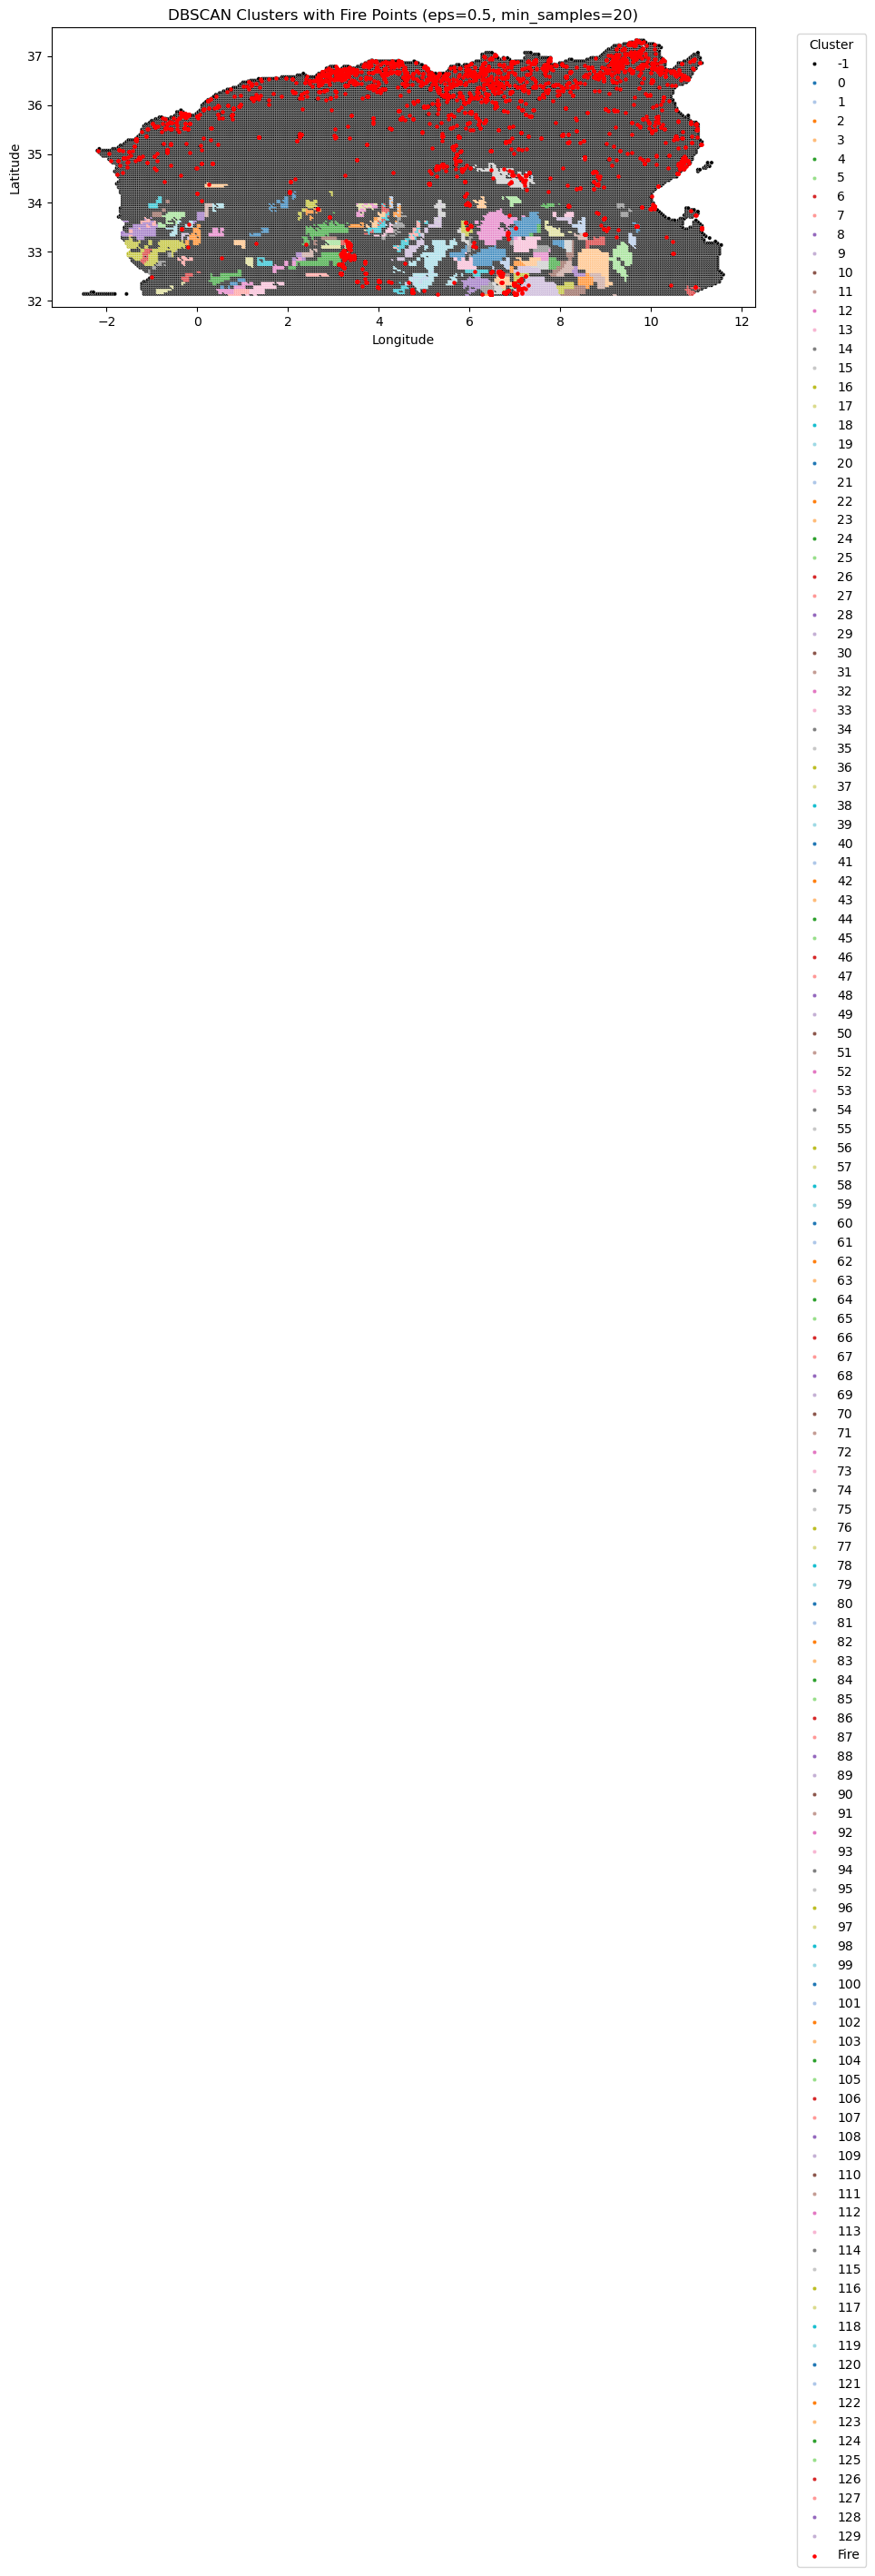

In [75]:
plt.figure(figsize=(10, 4))

# Define a custom color palette with black for noise points (-1)
# tab20 for other clusters, and explicitly map -1 to black.
custom_palette = {cluster: color for cluster, color in enumerate(sns.color_palette("tab20", len(data_plot['cluster'].unique()) - 1))}
custom_palette[-1] = 'black'  # Set noise points (-1) to black

# Plot clusters using the custom palette
sns.scatterplot(
    x='longitude', y='latitude',
    hue='cluster',
    palette=custom_palette,
    data=data_plot,
    legend='full',
    s=10
)

# Overlay fire points as small red dots
fire_points = data_plot[data_plot['fire'] > 0]  # only fire locations
plt.scatter(
    fire_points['longitude'],
    fire_points['latitude'],
    color='red',
    s=5,  
    label='Fire'
)

plt.title(f"DBSCAN Clusters with Fire Points (eps={best_eps}, min_samples={best_min_samples})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(os.path.join(image_dir, f"dbscan_clusters_with_fire_points_eps_{best_eps}_min_samples_{best_min_samples}.png"))
plt.show()

Clusters with fire counts being plotted: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129]


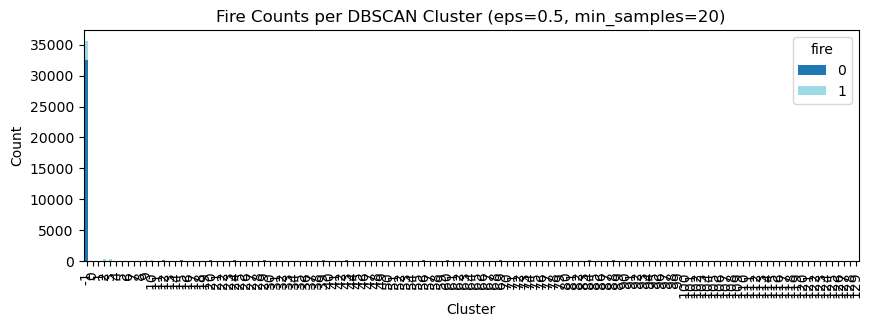

In [76]:
fire_counts = data_plot.groupby('cluster')['fire'].value_counts().unstack(fill_value=0)
# plot only cluster counts where fire is present (not 0)
fire_counts = fire_counts.loc[:, (fire_counts != 0).any(axis=0)]
# print clusters being plotted
print("Clusters with fire counts being plotted:", fire_counts.index.tolist())
fire_counts.plot(kind='bar', stacked=True, figsize=(10,3), colormap='tab20')
plt.title(f"Fire Counts per DBSCAN Cluster (eps={best_eps}, min_samples={best_min_samples})")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.savefig(os.path.join(image_dir, f"fire_counts_per_cluster_eps_{best_eps}_min_samples_{best_min_samples}.png"))
plt.show()